# Advanced Lane Finding    
[**Jean-Paul Wilson**](http://jpwilson.github.io "JP's Personal site")

## Introduction

The following notebook demonstrates an implementation of a lane finding algorithm that allows for the prediction of a vehicle's position relative to the lane lines, and the amount of curvature of the lanes on the road ahead. 
The process can be divided into the following main steps: 
1. Camera Lense Calibration and Distortion Correction.
2. Edge Detection with Color and Gradient Thresholding.
3. Perspective Transformation.
4. Determination of Lane Lines. 
5. Measure road curvature and Vehicle Location.

After importing all necessary libraries, the notebook will address the steps above sequentially. 

**Note: **Although the techniques implemented in this notebook may be useful for autonomous driving and driver assistance programs, it would not suffice on its own. One of the reasons for this is that several simplifying assumptions have been made, which are not applicable in the real world: 
* The road ahead of the vehicle is assumed to be flat, which is often not the case. 
* The location of the video recorder (dashcam) is assumed to be in the centre of the windshield of the car. 
* The height of the video recorder is assumed to be the same for all vehicles that would make use of it. 
* The road is a assumed to have lane lines. 


In [3]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import glob 
#from PIL import Image

### 1. Camera Lense Calibration and Distortion Correction

Camera lenses distort the images (radially because of their curvature on the edges, and tangentially when the plane of recording is not parallel to the image) warping their dimensions in the recorded image and video. This is potentially disastrous for autonomous driving, where an accurate interpretation of the vehicle's surroundings is paramount to safe operation. Therefore, in order to correct for the distortions, camera calibration is essential. Chessboard images are the most useful for this because it is simple to locate the corners in grayscaled images of the chessboards. Several cv2 methods are useful for the calibration process. These methods (with their inputs and outputs where applicable) include: 
> ret, corners = **cv2.findChessboardCorners**(img, pattern_size) 

> if ret; draw corners, else red circle: **cv2.drawChessboardCorners**(img, pattern_size, corners, ret)

> ret, mtx, dist, rvecs, tvecs = **cv2.calibrateCamera**(objpoints, imgpoints, img_shape, None, None)

> undist = **cv2.undistort**(img, mtx, dist, None, mtx)




Images seem larger sometimes | Wide angle distortion 
-|-
![dino](images/dinosaur-mirror_400x266.jpg) | ![dino](images/Car1_400x266.jpg) 

The calibration steps are as follows: 
1. Create an array of object points (which will be the same for each of the images used in the calibration process). 
2. Create an array of image points, from each of the images used in the calibration process. 
3. Read in the images, finding their corners, and appending them to the object point and image point arrays. 
4. Calibrate the images using the arrays from 3 above.
5. Transform (undistort) and then return the required image(s) for the next step in the lane finding process. 

C:\Users\jeanp\Miniconda3\envs\carnd-term1\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


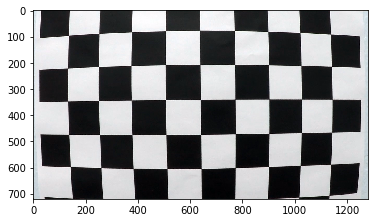

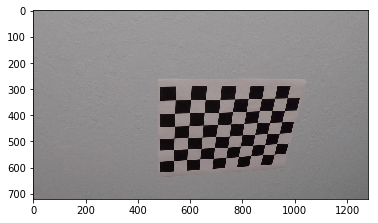

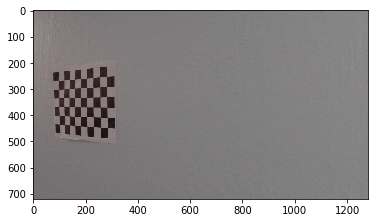

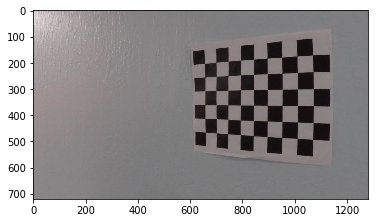

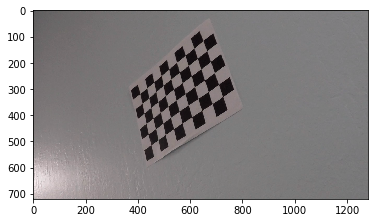

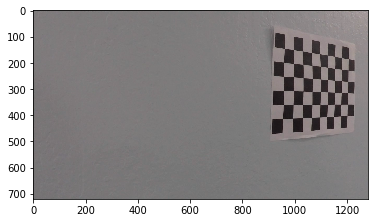

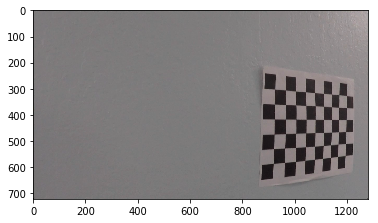

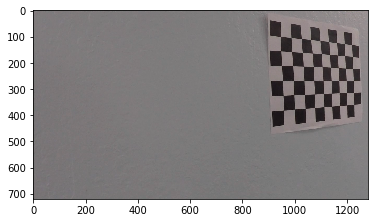

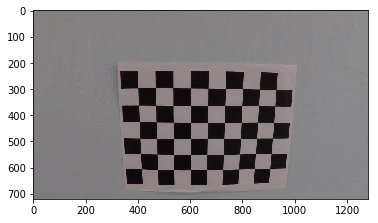

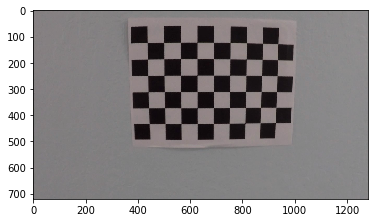

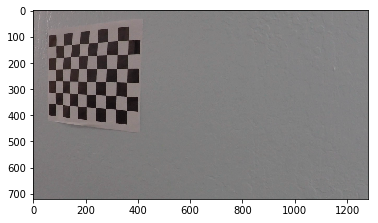

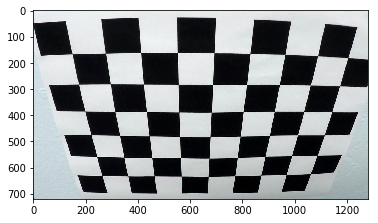

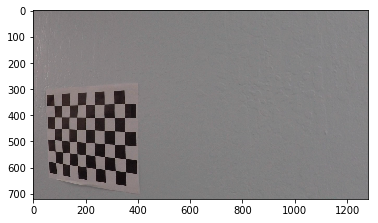

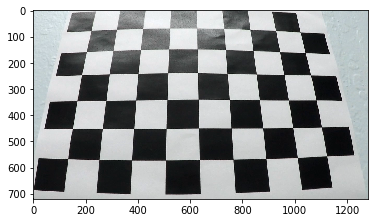

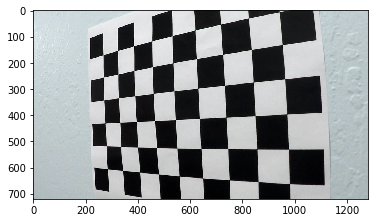

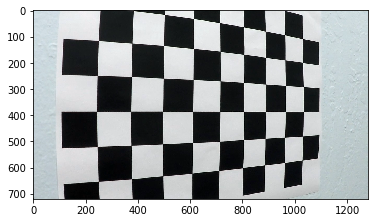

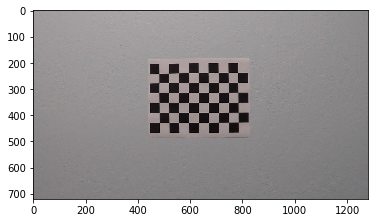

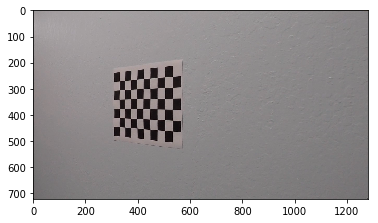

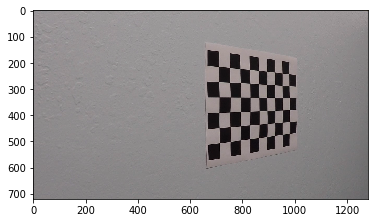

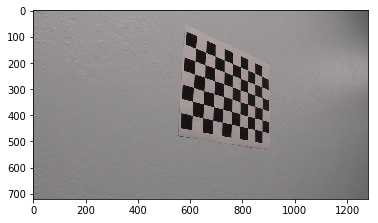

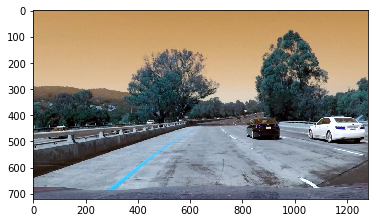

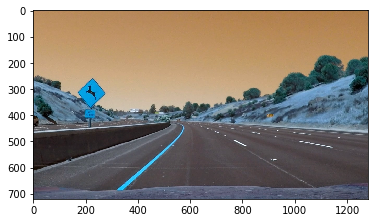

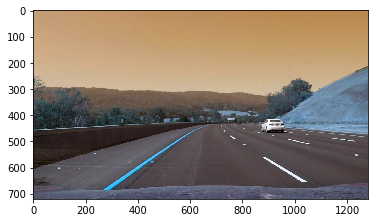

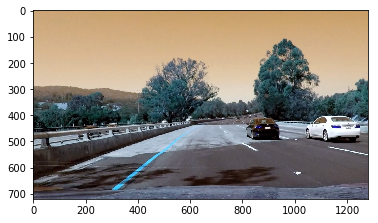

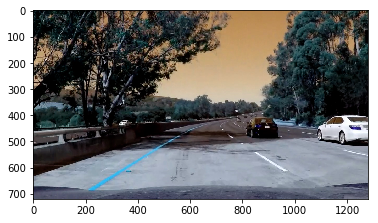

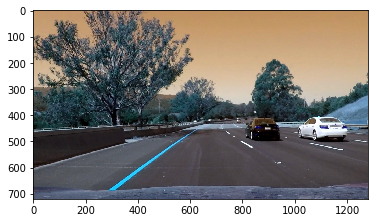

In [27]:
%matplotlib inline

images = glob.glob('CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_images = glob.glob('CarND-Advanced-Lane-Lines/test_images/test*.jpg')
read_in_pics = []

for e in images:
    plt.figure()
    image = cv2.imread(e)
    plt.imshow(image)
    

for e in test_images:
    plt.figure()
    image = cv2.imread(e)
    plt.imshow(image)
    
#Will delete this later, just checking that I can read in all of the images...
'''
img_2_test = mpimg.imread(test_images[2])
plt.figure()
print("After images but before calibrated")
plt.imshow(img_2_test)
print("After image but before calibrated")
plt.imshow(calibrate_undistort(img_2_test,objpoints, imgpoints))'''

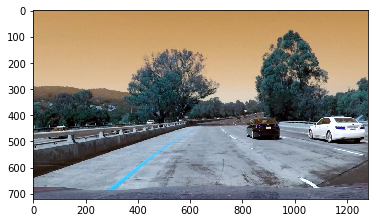

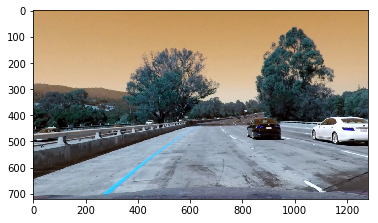

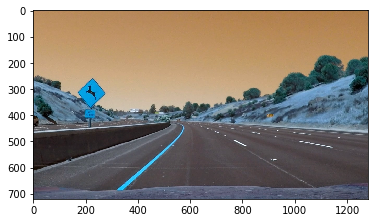

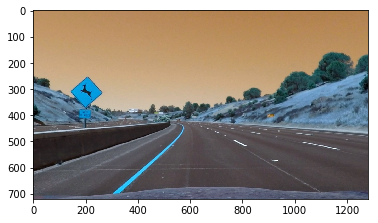

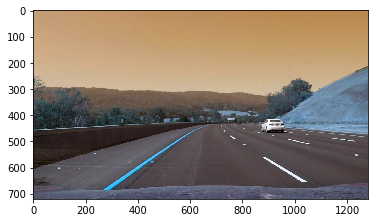

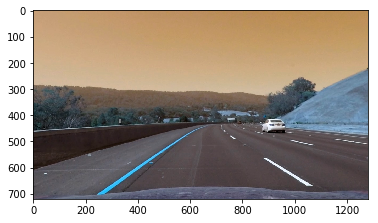

In [40]:
%matplotlib inline

images = glob.glob('CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_images = glob.glob('CarND-Advanced-Lane-Lines/test_images/test*.jpg')


objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

nx, ny = 9, 6

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #plt.figure()
    if ret == True:  
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)

#Defining a method for the calibration and image undistortion:
def calibrate_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[:2]), None, None)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

'''
for e in test_images[:3]:
    image = cv2.imread(e)
    undist = calibrate_undistort(image, objpoints, imgpoints)
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(undist)
    #print("b4 distorted")
    #print("after distorted")
    #print("b4 fixed")'
    #print("after fixed")'''



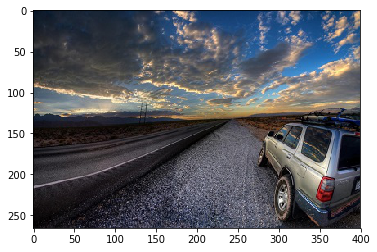

error: ..\..\..\modules\calib3d\src\calibration.cpp:3314: error: (-215) nimages > 0 in function cv::calibrateCamera


In [3]:
%matplotlib inline
image = mpimg.imread("images/Car1_400x266.jpg")
plt.figure()
plt.imshow(image)
plt.show()

fixed = calibrate_undistort(image, objpoints, imgpoints)
plt.imshow(fixed)
plt.show()



## 2. Edge Detetion

Two types of thresholding are done for the purposes of locating lane lines; color and gradient. 
For best results in varying lighting conditions and for different color lane lines, the two thresholding techniques are combined. 

### 2.1. Gradient Thresholding
The Sobel operator is a method of edge detection which takes the derivative of a matrix of an image's grayscaled pixel values 
in either the x or y direction. 
- The sobel operator is a square matrix of odd dimensions (3, 5, 7, etc). Taking the Sobel of an image with uniform pixel values returns a value of zero. 
- Sobel in the x direction detects predominantly vertical edges while conversely, Sobel - y detects horizontal images. 
- As lane lines are generally oriented in 45 degree orientation, a combination of both Sobel operators is necessary. 
- Three methods of detection are implemented and combined, with tuning of the thresholds required for optimum results: 
    * Absolute value thresholding of Sobel x or Sobel y
    * Gradient Magnitude 
    * Gradient Direction



        

In [4]:
def abs_sobel_thresh(img, orient='x', s_kernel = 3, thresh=(0,255)):
    sobelx = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel))
    scaled_sobel = np.uint8(255*abs_soble/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary 

def mag_thresh(img, s_kernel= 3, thresh=(0, 255)): 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel)
    gradmag = np.sqrt(np.square(sobelx) + np.sqare(sobely))
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag < thresh[1])] = 1
    return binary_output 

def dir_thresh(img, s_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel))
    grad_dir = np.arctan2(abs_sobelx, abs_sobely)
    bin_mask = np.zeros_like(grad_dir)
    bin_mask[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    return bin_mask


### 2.2. Color Thresholding

There are several ways to categorize colors and represent them in digital images. These representations are called color spaces. Three of the most common color spaces are:
- RGB: Red, Green, Blue 
- HSV: Hue, Saturation, Value
- HLS: Hue, Lightness, Saturation

After experimenting with the three color spaces, separating their channels and testing on different images of roads with the lane lines in different lighting conditions and of different colors, it was found that **S**aturation in the HLS color space performs best overall for color thresholding, even though it is not the best in every situation. (For example, the Red channel of RGB still performs best for white lines, under constant, bright lighting (no shadows). 

In [6]:
def hls_saturation(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_op = np.zeros_like(S)
    binary_op[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_op

Now, for the best edge detetion algorithm, the four methods above are combined